In [1]:
import pandapower as pp 
import pandapower.plotting as plot
import numpy as np
import pandas as pd
import math
import json
import matplotlib.pyplot as plt
import os
import pandapower.networks as nw
import random


In [2]:
net = nw.pp.create_empty_network() #create an empty net

In [3]:
# Loading the nodes, created in the NetworkX file: XNetwork_grid

# all nodes
nodes_orig = pd.read_csv('network_data/nodes_with_im.csv')
nodes_orig['NodeID'] = nodes_orig['NodeID'].astype(str) 

# subnetwork connection nodes
sub_con_nodes = pd.read_csv('network_data/sub_con_nodes.csv')
sub_con_nodes['NodeID'] = sub_con_nodes['NodeID'].astype(str) 

# subnetwork nodes
subnet_nodes = pd.read_csv('network_data/subnet_nodes.csv')
subnet_nodes['NodeID'] = subnet_nodes['NodeID'].astype(str) 

frames = [nodes_orig,sub_con_nodes,subnet_nodes] 
nodes_complet = pd.concat(frames)

#open island grids to assign a bus with a rated voltage (in each island is the same voltage level)

with open('network_data/grid_island.json') as json_data:
    grid_islands = json.load(json_data)
    
# island grid with 2 is the 21 kV mid grid
grid_mid_21 = pd.DataFrame.from_dict(grid_islands['2'])
grid_mid_21 = grid_mid_21.rename(columns = {0:'NodeID'}) 
# island grid with 3 is the 10 kV mid grid
grid_mid_10 = pd.DataFrame.from_dict(grid_islands['3'])
grid_mid_10 = grid_mid_10.rename(columns = {0:'NodeID'}) 

grid_mid_21['r_voltage'] = 21.0
grid_mid_10['r_voltage'] = 10.6
grid_mid = pd.concat([grid_mid_10,grid_mid_21])

grid_low = nodes_complet[~nodes_complet['NodeID'].isin(grid_mid['NodeID'])]
grid_low['r_voltage'] = 0.42
grid_low = grid_low[['NodeID', 'r_voltage']]

frames = [grid_mid, grid_low]
grid_nodes = pd.concat(frames)

grid_nodes = pd.merge(grid_nodes, nodes_complet, on = 'NodeID', how='inner')

grid_nodes.loc[2503]

NodeID       52933794
r_voltage        0.42
CoordX         554121
CoordY         145768
Name: 2503, dtype: object

In [4]:
### Deleting the spotload and photovoltaic nodes, since they do not physical exist and 
### their connection lines has zero length

node_spotload = grid_nodes[grid_nodes['NodeID'].str.contains('SPOTLOAD')] # not needed
node_pv = grid_nodes[grid_nodes['NodeID'].str.contains('PHOTO')] # not needed
grid_nodes = grid_nodes[~grid_nodes['NodeID'].str.contains('SPOTLOAD')]
grid_nodes = grid_nodes[~grid_nodes['NodeID'].str.contains('PHOTO')]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(grid_nodes)
grid_nodes

,NodeID,r_voltage,CoordX,CoordY
0,52833446,10.60,553601.965959,146367.141821
1,42961390,10.60,553608.000000,146386.000000
2,42882781,10.60,554436.000000,146391.000000
3,42907481,10.60,554305.000000,146539.000000
4,42941338,10.60,553686.000000,146249.000000
5,42907485,10.60,554305.000000,146539.000000
6,52034685,10.60,554436.000000,146391.000000
7,42976839,10.60,553964.000000,146370.000000
8,42966813,10.60,553963.000000,146150.000000
9,42891763,10.60,553963.000000,146150.000000


In [5]:
### Nodes/busses creation

for i, row in grid_nodes.iterrows():
    pp.create_bus(net, name=row.NodeID, vn_kv=row.r_voltage, geodata = (row.CoordX,row.CoordY))

In [6]:
net.bus
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(net.bus)

,name,vn_kv,type,zone,in_service
0,52833446,10.60,b,None,True
1,42961390,10.60,b,None,True
2,42882781,10.60,b,None,True
3,42907481,10.60,b,None,True
4,42941338,10.60,b,None,True
5,42907485,10.60,b,None,True
6,52034685,10.60,b,None,True
7,42976839,10.60,b,None,True
8,42966813,10.60,b,None,True
9,42891763,10.60,b,None,True


In [7]:
### Loading the section csv for the lines

section = pd.read_csv('network_data/result_section_better.csv', header=0)

section = section[['SectionID', 'FromNodeID', 'ToNodeID']]
section['FromNodeID'] = section['FromNodeID'].astype(int)

#section

In [8]:
### Loading the information: cable from equipment.txt and underground settings from Network.txt (Romand Energy)
### Combining them to cable
cable = pd.read_csv('network_data/cable.csv')
ug_cable = pd.read_csv('network_data/ug_cable_network.csv', header=0)

ug_cable = ug_cable.rename(index=str, columns={"LineCableID":"ID"})

ug_cable = ug_cable[["ID","SectionID", "Length"]].copy()
cable= cable.merge(ug_cable, on='ID')

cable

,ID,R1,R0,X1,X0,B1,B0,Amps,Amps_1,Amps_2,...,ConcentricNeutralBeforeSheath,UserDefinedImpedances,Frequency,Temperature,ImpedancesNote,Favorite,Flags,Comments,SectionID,Length
0,B-G-2X95,0.2049,1.0,0.040,1.0,421.30,1.0,440.0,440.0,440.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43852184,49.0
1,B-T-95+N,0.0000,0.0,0.000,0.0,0.00,0.0,1.0,1.0,1.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43824608,60.0
2,B-TDC-6-RE,3.5639,0.0,0.100,0.0,345.58,0.0,50.0,50.0,50.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,44023328,2.0
3,B-X-150-AL,0.2633,0.0,0.078,0.0,230.36,0.0,290.0,290.0,290.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43826761,10.0
4,B-X-150-AL,0.2633,0.0,0.078,0.0,230.36,0.0,290.0,290.0,290.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43827341,23.0
5,B-X-150-AL,0.2633,0.0,0.078,0.0,230.36,0.0,290.0,290.0,290.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43826091,1.0
6,B-X-150-AL,0.2633,0.0,0.078,0.0,230.36,0.0,290.0,290.0,290.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43826021,42.0
7,B-X-150-AL,0.2633,0.0,0.078,0.0,230.36,0.0,290.0,290.0,290.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43826391,31.0
8,B-X-150-AL,0.2633,0.0,0.078,0.0,230.36,0.0,290.0,290.0,290.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43825941,38.0
9,B-X-150-AL,0.2633,0.0,0.078,0.0,230.36,0.0,290.0,290.0,290.0,...,0,1,-1.0,-274.0,NaN,0,0,NaN,43825961,40.0


In [9]:
### Transformer input, connecting with the node voltage informations 
### transformer from equipment.txt 
### transformer settings from network.txt

transformer = pd.read_csv('network_data/transformer.csv')

transformer_settings = pd.read_csv('network_data/transformer_settings.csv')

transformer_settings = transformer_settings.rename(index=str, columns={"ID": "EqID"})

transformer = transformer.merge(transformer_settings, 'outer', 'EqID')

transformer_orig = transformer.dropna(subset=['SectionID'])


transformer = transformer_orig[["SectionID" , "KVA", "KVLLprim", "KVLLsec","Z1", 'XR','MaxBoost', "NoLoadLosses"]].copy()



### standard transformer on this voltage level seems to have all identical parameters for the following
transformer['shift_degree'] = 150
transformer['tp_side'] = 'hv'
transformer['tp_mid'] = 0
transformer['tp_min'] = -2
transformer['tp_max'] = 2
transformer['tp_st_percent'] = 2.5
transformer['tp_st_degree'] = 0

### The calculation of the real component of short circuit voltage [%] is not clear for me,
### two approches that I found leads to different results:
### Approch 1 ###
#### V_scr (in%) = abs(Z) = sqrt(X^2+R^2);
#### Note that Z, X, and R are the impedance, inductance and resistance in p.u.
#transformer['v_scr'] = abs(transformer['Z1']) # 
### Approch 2 ### 
#R_sq = (transformer['Z1']**2) /(1+(transformer['XR']**2)).astype(float)
#transformer['v_scr'] = R_sq**(1/2)

#### Open loop losses represents the shunt (magnetization) branch in the electrical model of transformers.
########## If you have no data about it you could put i_0 = 0; It means you neglected this branch which is a practical assumption.
transformer['i_0'] = 0 # open loop losses [%] missing/zero is assumed

#### Maximum loading of a transformer with respect to its rated power is the maximum power that a transformer 
########## could transfer it for a short period of time without damages.
########## If you have no data for this, you could assume maximum loading power is 20-30% higher than the rated power (very approximative assumption).
transformer['max_loading'] = 'NaN' # maximum loading of the trafo with respect to rated
                                   # apparent power and its corresponding current at 1 p.u. 
                                   # It is not a required parameter for a power flow run

#### noloadlosses =~ iron losses : pfe_kw
transformer= transformer.rename(columns = {'NoLoadLosses':'pfe_kw'})

#### short circuit voltage: for 20/0.4 and 10/0.4 (according to the standard types)
transformer.loc[transformer['KVLLprim'] == 10.6, 'v_sc'] = 4
transformer.loc[transformer['KVLLprim'] == 21.0, 'v_sc'] = 6



transformer[["SectionID"]] = transformer[["SectionID"]].astype(int)
transformer[["SectionID"]] = transformer[["SectionID"]].astype(str)


transformer

,SectionID,KVA,KVLLprim,KVLLsec,Z1,XR,MaxBoost,pfe_kw,shift_degree,tp_side,tp_mid,tp_min,tp_max,tp_st_percent,tp_st_degree,i_0,max_loading,v_sc
0,42547360,400.0,10.6,0.42,3.81,3.674,5.13,0.680,150,hv,0,-2,2,2.5,0,0,NaN,4.0
1,42571987,630.0,10.6,0.42,4.28,6.224,4.76,0.627,150,hv,0,-2,2,2.5,0,0,NaN,4.0
2,42590298,400.0,10.6,0.42,3.83,3.688,5.13,0.678,150,hv,0,-2,2,2.5,0,0,NaN,4.0
3,42552624,100.0,10.6,0.42,4.20,2.221,2.50,0.342,150,hv,0,-2,2,2.5,0,0,NaN,4.0
4,42574167,630.0,21.0,0.42,4.28,6.327,4.76,0.594,150,hv,0,-2,2,2.5,0,0,NaN,6.0
5,214551743,630.0,21.0,0.42,4.21,7.020,4.76,0.612,150,hv,0,-2,2,2.5,0,0,NaN,6.0
6,42595956,10000.0,21.0,10.60,8.63,13.698,10.00,9.300,150,hv,0,-2,2,2.5,0,0,NaN,6.0
7,42613835,630.0,21.0,0.42,4.26,6.157,4.76,0.624,150,hv,0,-2,2,2.5,0,0,NaN,6.0
8,42571862,630.0,10.6,0.42,4.29,6.210,4.76,0.630,150,hv,0,-2,2,2.5,0,0,NaN,4.0
9,42574494,630.0,21.0,0.42,4.10,5.904,4.76,0.642,150,hv,0,-2,2,2.5,0,0,NaN,6.0


In [10]:
### Given each transformer a FromNode and a ToNode based on the Section
transformer = pd.merge(transformer, section, on='SectionID', how='inner')
#transformer
section

,SectionID,FromNodeID,ToNodeID
0,42571222,42901266,42901267
1,42533575,42890834,42890827
2,43939209,42787380,42687308
3,43825506,42698357,42684664
4,43971553,42703621,42694044
5,94588448,52857530,94588294
6,42783662-SPOTLOAD,42783662,42783662-SPOTLOAD
7,43895417,52889602,42697592
8,42533570,42890835,42890827
9,43906026,42785340,42692978


In [11]:
### Rearrangement of the transformer information, to identify the high voltage node and the low voltage node
### grid_nodes store the grid islands, where every node has the same voltage niveau

grid_nodes_2 = grid_nodes[['NodeID','r_voltage']]

### Giving each transformer FromNode the volage niveau 
grid_nodes_2 = grid_nodes_2.rename(columns={'NodeID':'FromNodeID','r_voltage':'from_r_voltage'})
transformer['FromNodeID'] = transformer['FromNodeID'].astype(str)
grid_nodes_2['FromNodeID'] = grid_nodes_2['FromNodeID'].astype(str)
transformer = pd.merge(transformer, grid_nodes_2, on='FromNodeID', how='inner')

### Given each transformer ToNode a voltage level
grid_nodes_3 = grid_nodes_2.rename(columns={'FromNodeID':'ToNodeID','from_r_voltage':'to_r_voltage'})
transformer = pd.merge(transformer, grid_nodes_3, on='ToNodeID', how='inner')

transformer
### Transformers are not declared in an uniform way, rearrange as: Prim = From, sec = To

,SectionID,KVA,KVLLprim,KVLLsec,Z1,XR,MaxBoost,pfe_kw,shift_degree,tp_side,...,tp_max,tp_st_percent,tp_st_degree,i_0,max_loading,v_sc,FromNodeID,ToNodeID,from_r_voltage,to_r_voltage
0,42547360,400.0,10.6,0.42,3.81,3.674,5.13,0.680,150,hv,...,2,2.5,0,0,NaN,4.0,42934975,42934976,0.42,10.60
1,42571987,630.0,10.6,0.42,4.28,6.224,4.76,0.627,150,hv,...,2,2.5,0,0,NaN,4.0,42883121,42905802,0.42,10.60
2,42590298,400.0,10.6,0.42,3.83,3.688,5.13,0.678,150,hv,...,2,2.5,0,0,NaN,4.0,42932969,42980182,0.42,10.60
3,42552624,100.0,10.6,0.42,4.20,2.221,2.50,0.342,150,hv,...,2,2.5,0,0,NaN,4.0,42882930,42878165,0.42,10.60
4,42574167,630.0,21.0,0.42,4.28,6.327,4.76,0.594,150,hv,...,2,2.5,0,0,NaN,6.0,42902143,42902140,0.42,21.00
5,214551743,630.0,21.0,0.42,4.21,7.020,4.76,0.612,150,hv,...,2,2.5,0,0,NaN,6.0,214550146,105470910,0.42,21.00
6,42595956,10000.0,21.0,10.60,8.63,13.698,10.00,9.300,150,hv,...,2,2.5,0,0,NaN,6.0,42941227,42882789,21.00,10.60
7,42613835,630.0,21.0,0.42,4.26,6.157,4.76,0.624,150,hv,...,2,2.5,0,0,NaN,6.0,42951838,42951839,21.00,0.42
8,42571862,630.0,10.6,0.42,4.29,6.210,4.76,0.630,150,hv,...,2,2.5,0,0,NaN,4.0,42891069,42891068,10.60,0.42
9,42574494,630.0,21.0,0.42,4.10,5.904,4.76,0.642,150,hv,...,2,2.5,0,0,NaN,6.0,42881441,42945679,0.42,21.00


In [12]:
### Transformer site with 21 kV is always a "from node" and are therefore correct
transformer_prim_from = transformer[transformer['from_r_voltage'] == 21.00]
### Transformer site with 0.4 kV is alwayse a "to node"  and therefore correct
transformer_sec_to = transformer[transformer['to_r_voltage'] == 0.42]
### Transformer with 21 kV as "to node" side need to be rearranged, since it is always a "from node"
transformer_21_sec = transformer[transformer['to_r_voltage'] == 21.00]
transformer_21_sec = transformer_21_sec.rename(columns = {'from_r_voltage':'to_r_voltage', 'to_r_voltage':'from_r_voltage',
                                                         'FromNodeID':'ToNodeID','ToNodeID':'FromNodeID'})
### Transformer with 0.4 kV as "from node" need to be rearranged
transformer_04_prim = transformer[transformer['from_r_voltage'] == 0.42]
transformer_04_prim = transformer_04_prim.rename(columns = {'from_r_voltage':'to_r_voltage', 'to_r_voltage':'from_r_voltage',
                                                           'FromNodeID':'ToNodeID','ToNodeID':'FromNodeID'})
 
frames = [transformer_sec_to, transformer_prim_from,transformer_21_sec,transformer_04_prim]
transformer = pd.concat(frames).drop_duplicates().reset_index(drop=True)


In [13]:
### Transformer connecting 21 and 10 kV grid, which is not in the data
transformer_select = transformer[transformer['KVLLsec'] == 10.6]
 ####	43994411 	52117850 	52113248
transformer_imagine = transformer_select[transformer_select['Z1'] == 7.42]
transformer_imagine['FromNodeID'] = '52117850'
transformer_imagine['SectionID'] = '43994411'
transformer_imagine['ToNodeID'] = '52113248'
transformer_imagine
#transformer = transformer.append(transformer_imagine)

,FromNodeID,KVA,KVLLprim,KVLLsec,MaxBoost,SectionID,ToNodeID,XR,Z1,from_r_voltage,...,pfe_kw,shift_degree,to_r_voltage,tp_max,tp_mid,tp_min,tp_side,tp_st_degree,tp_st_percent,v_sc
18,52117850,10000.0,21.0,10.6,10.0,43994411,52113248,14.572,7.42,21.0,...,8.88,150,10.6,2,0,-2,hv,0,2.5,6.0


In [14]:
### Only considering the section, with mid voltage given in dataframe grid and are not a transformer section

section = section[~section['SectionID'].isin(transformer['SectionID'])].reset_index()
section = section.applymap(str)
section = section[['SectionID','FromNodeID', 'ToNodeID']]
section = section.drop_duplicates(subset="SectionID")

### Creating the spotload sections 
section_spotload = section[section['SectionID'].str.contains('SPOTLOAD')].reset_index()
section = section[~section['SectionID'].str.contains('SPOTLOAD')]

### Creating the pv sections
section_pv = section[section['SectionID'].str.contains('PHOTOV')].reset_index()
section = section[~section['SectionID'].str.contains('PHOTOVO')]

#section_spotload



In [15]:
### Combining information of cable (created with cable and underground settings) with sections
### Giving each node connection physical parameters 

cable['SectionID'] = cable['SectionID'].astype(str)
section['SectionID'] = section['SectionID'].astype(str) 

cable_section = pd.merge(section, cable, on='SectionID', how='inner')

cable_section.drop_duplicates(subset="SectionID").reset_index()

#cable_section

,index,SectionID,FromNodeID,ToNodeID,ID,R1,R0,X1,X0,B1,...,OverallDiameter,ConcentricNeutralBeforeSheath,UserDefinedImpedances,Frequency,Temperature,ImpedancesNote,Favorite,Flags,Comments,Length
0,0,42571222,42901266,42901267,B-FIC,0.4158,1.00,0.3269,1.000,3.544,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,0.0
1,1,42533575,42890834,42890827,B-FIC,0.4158,1.00,0.3269,1.000,3.544,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,0.0
2,2,43939209,42787380,42687308,B-GKN-K-16,1.4662,0.00,0.0900,0.000,137.500,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,7.0
3,3,43825506,42698357,42684664,B-P-50+25,0.4476,0.00,0.0900,0.000,282.740,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,18.0
4,4,43971553,42703621,42694044,B-XN-150-AL,0.2633,0.00,0.0780,0.000,230.360,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,238.0
5,5,94588448,52857530,94588294,B-GKN-K-150 AL+95,0.2450,1.00,0.0710,1.000,1.000,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,34.0
6,6,43895417,52889602,42697592,B-T-95,0.2238,0.00,0.0820,0.000,706.680,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,3.0
7,7,42533570,42890835,42890827,B-FIC,0.4158,1.00,0.3269,1.000,3.544,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,0.0
8,8,43906026,42785340,42692978,B-P-25+16,0.8409,0.00,0.0940,0.000,259.180,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,4.0
9,9,43939204,42660293,42793224,B-P-5,4.7100,0.00,0.1200,0.000,123.700,...,28.0,0,1,-1.0,-274.0,NaN,0,0,NaN,11.0


In [16]:
### Testing if all sections have been assigned with a cable (should be empty)
cable_section['SectionID'] = cable_section['SectionID'].astype(str)
section['SectionID'] = section['SectionID'].astype(str)

cable_section_test = cable_section[~cable_section['SectionID'].isin(section['SectionID'])]

cable_section_test

,SectionID,FromNodeID,ToNodeID,ID,R1,R0,X1,X0,B1,B0,...,OverallDiameter,ConcentricNeutralBeforeSheath,UserDefinedImpedances,Frequency,Temperature,ImpedancesNote,Favorite,Flags,Comments,Length


In [17]:
### Some sections has zero lenth or/and zero impedance and will be created as switches 

cable_section_low_imp = cable_section[cable_section['X1'] < 0.005]
cable_section_zero_length =  cable_section[cable_section['Length'] < 0.05]

# Deleting the special cases from the line/cable section
cable_section = cable_section[cable_section['X1'] >= 0.005]
cable_section = cable_section[cable_section['Length'] >= 0.05]



In [18]:
#cable_section_low_imp

In [19]:
#cable_section_zero_length


In [20]:
### only important columns 
cable_section = cable_section[[
 'SectionID',
 'FromNodeID',
 'ToNodeID',
 'ID',
 'R1',
 'R0',
 'X1',
 'X0',
 'B1',
 'B0',
 'Amps',
 'Amps_1',
 'Amps_2',
 'Amps_3',
 'Amps_4',
 'Length']]
#cable_section

In [21]:
### To plot the network, pandapower needs coordinates of their sections:
#### creating two columns (X,Y) with the coordinates of the FromNodeID
nodes_from = nodes_complet.rename(columns = {'NodeID':'FromNodeID'}) 
cable_section_from = pd.merge(cable_section, nodes_from, on='FromNodeID', how='inner')
cable_section_from = cable_section_from.rename(columns = {'CoordX':'FromCoordX', 'CoordY':'FromCoordY'})

#### creating two columns (X,Y) with the coordinates of the ToNodeID
nodes_to = nodes_complet.rename(columns = {'NodeID':'ToNodeID'}) 
cable_section_coord = pd.merge(cable_section_from, nodes_to, on='ToNodeID', how='inner')
cable_section_coord = cable_section_coord.rename(columns = {'CoordX':'ToCoordX', 'CoordY':'ToCoordY'})

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(cable_section_coord)

In [22]:
# creating the lines, without low impedance and length cable

for _, hv_line in cable_section_coord.iterrows():
        from_bus = pp.get_element_index(net, "bus", hv_line.FromNodeID)
        to_bus = pp.get_element_index(net, "bus", hv_line.ToNodeID)
        coord = ([(hv_line.FromCoordX, hv_line.FromCoordY),(hv_line.ToCoordX,hv_line.ToCoordY)])
        pp.create_line_from_parameters(net, from_bus, to_bus, length_km=hv_line.Length/1000,
                                       r_ohm_per_km = hv_line.R1, x_ohm_per_km = hv_line.X1, 
                                       c_nf_per_km = 1000/(hv_line.B1 *math.pi*2*50) ,
                                       max_i_ka = hv_line.Amps_4/1000, name=hv_line.SectionID , parallel=1,
                                       type = "cs", geodata = coord, df = 1 )

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(net.line)

In [23]:
 
net.line # 978
net.line_geodata

,coords
0,"[(554020.475, 146396.927), (554025.194, 146400..."
1,"[(554018.517, 146409.068), (554025.194, 146400..."
2,"[(554031.871, 146392.063), (554025.194, 146400..."
3,"[(554007.887, 146422.604), (554003.163, 146428..."
4,"[(553992.0, 146424.0), (554003.163, 146428.620..."
5,"[(554016.16, 146347.766), (553866.93, 146402.2..."
6,"[(553864.373767, 146409.474934), (553866.93, 1..."
7,"[(554109.3811090001, 146311.74646199998), (554..."
8,"[(553992.0, 146424.0), (554003.818, 146421.31)]"
9,"[(554025.1070000001, 146394.201), (554003.818,..."


In [24]:
net.line_geodata['coords'][0]

[(554020.475, 146396.927), (554025.194, 146400.566)]

In [25]:
# Bus-bus switches

for _, switch_line in cable_section_zero_length.iterrows():
    from_bus = pp.get_element_index(net, "bus", switch_line.FromNodeID)
    to_bus = pp.get_element_index(net, "bus", switch_line.ToNodeID)
    pp.create_switch(net, from_bus, to_bus, et='b', closed=True, name=switch_line.SectionID)
    
for _, switch_line in cable_section_low_imp.iterrows():
    from_bus = pp.get_element_index(net, "bus", switch_line.FromNodeID)
    to_bus = pp.get_element_index(net, "bus", switch_line.ToNodeID)
    pp.create_switch(net, from_bus, to_bus, et='b', closed=True, name=switch_line.SectionID)



In [26]:
net.switch
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(net.switch)

       bus  element et  type  closed       name
0     2504     2503  b  None    True   42571222
1     3019     1923  b  None    True   42533575
2     3020     1923  b  None    True   42533570
3     2513     1923  b  None    True   93849829
4     3021     2504  b  None    True   42571224
5     3024     2504  b  None    True   42571223
6     3022     1923  b  None    True   42533571
7     3025     2504  b  None    True   42571225
8     1923     2508  b  None    True   93849824
9     3027     1923  b  None    True   42533572
10    3028     1923  b  None    True   42533569
11    3029     2504  b  None    True   42571226
12    3026     1923  b  None    True   42533574
13    3031     1923  b  None    True   42533573
14    3034     2504  b  None    True   42571227
15     316      230  b  None    True   42575388
16     244      280  b  None    True   42549833
17     403      330  b  None    True   42613833
18     454      452  b  None    True   42535653
19     348      398  b  None    True   4

In [27]:
transformer

,FromNodeID,KVA,KVLLprim,KVLLsec,MaxBoost,SectionID,ToNodeID,XR,Z1,from_r_voltage,...,pfe_kw,shift_degree,to_r_voltage,tp_max,tp_mid,tp_min,tp_side,tp_st_degree,tp_st_percent,v_sc
0,42951838,630.0,21.0,0.42,4.76,42613835,42951839,6.157,4.26,21.0,...,0.624,150,0.42,2,0,-2,hv,0,2.5,6.0
1,42891069,630.0,10.6,0.42,4.76,42571862,42891068,6.210,4.29,10.6,...,0.630,150,0.42,2,0,-2,hv,0,2.5,4.0
2,88865776,1000.0,21.0,0.42,4.76,90147807,89563419,8.669,5.79,21.0,...,0.790,150,0.42,2,0,-2,hv,0,2.5,6.0
3,42894295,1000.0,10.6,0.42,4.76,42546221,42966104,9.385,6.03,10.6,...,0.767,150,0.42,2,0,-2,hv,0,2.5,4.0
4,42891762,630.0,10.6,0.42,4.76,42554475,42905803,6.235,4.29,10.6,...,0.630,150,0.42,2,0,-2,hv,0,2.5,4.0
5,42910701,630.0,10.6,0.42,4.76,42576832,42910585,6.353,4.19,10.6,...,0.598,150,0.42,2,0,-2,hv,0,2.5,4.0
6,42935046,400.0,10.6,0.42,4.76,214659777,109996361,5.291,4.25,10.6,...,0.459,150,0.42,2,0,-2,hv,0,2.5,4.0
7,42984903,630.0,21.0,0.42,4.76,42609997,42951136,5.944,3.94,21.0,...,0.670,150,0.42,2,0,-2,hv,0,2.5,6.0
8,192652303,1000.0,21.0,0.42,4.76,42548089,175586744,8.044,6.06,21.0,...,0.791,150,0.42,2,0,-2,hv,0,2.5,6.0
9,42951143,630.0,21.0,0.42,4.76,42566172,42883602,5.475,3.94,21.0,...,0.684,150,0.42,2,0,-2,hv,0,2.5,6.0


In [28]:
trafotypes = []
for _, trafo in transformer.iterrows():
    trafotyp = {'trafo_' + str(trafo.SectionID):{'sn_kva': trafo.KVA,'vn_hv_kv': trafo.KVLLprim,
                                'vn_lv_kv': trafo.KVLLsec,
                                'vsc_percent': trafo.v_sc,'vscr_percent':1.3 ,'pfe_kw':trafo.pfe_kw ,
                                'i0_percent':0 ,'shift_degree': 150, 'tp_side': 'hv',
                                 'tp_mid':0 ,'tp_min':-2 ,'tp_max':2 ,'tp_st_percent':2.5,'tp_st_degree':0,
                                 'tp_pos': 0,'parallel':1, 'df':1 }}
    pp.create_std_types(net, data=trafotyp, element="trafo")


In [29]:
### Liberay for the transformers
## Either I create them (1) or I directly use the parameters from the transformer table (2), currently I prefer the second approach, so this block is commented

trafotypes = {"0.1 MVA 10/0.4 kV":{'sn_kva': 100,'vn_hv_kv': 10.6, 'vn_lv_kv': 0.4, 'vsc_percent': 6,
                                 'vscr_percent':1.46 ,'pfe_kw':0.342 ,'i0_percent':0 ,'shift_degree': 150, 'tp_side': 'hv',
                                 'tp_mid':0 ,'tp_min':-2 ,'tp_max':2 ,'tp_st_percent':2.5,'tp_st_degree':0,
                                 'tp_pos': 0,'parallel':1, 'df':1 },
              "1 MVA 10/0.4 kV": {'sn_kva': 1000,'vn_hv_kv': 20, 'vn_lv_kv': 0.4, 'vsc_percent': 6,
                                 'vscr_percent': 1.25 ,'pfe_kw': 6,'i0_percent': 0,'shift_degree': 150, 'tp_side': 'hv',
                                 'tp_mid':0 ,'tp_min':-2 ,'tp_max':2 ,'tp_st_percent':2.5,'tp_st_degree':0,
                                 'tp_pos': 0,'parallel':1, 'df':1  } ,
              "1 MVA 20/0.4 kV": {'sn_kva': 1000,'vn_hv_kv': 20, 'vn_lv_kv': 0.4, 'vsc_percent': 6,
                                 'vscr_percent': 1.15 ,'pfe_kw': 6,'i0_percent': 0,'shift_degree': 150, 'tp_side': 'hv',
                                 'tp_mid':0 ,'tp_min':-2 ,'tp_max':2 ,'tp_st_percent':2.5,'tp_st_degree':0,
                                 'tp_pos': 0,'parallel':1, 'df':1  } ,
              "10 MVA 20/10 kV": {'sn_kva': 10000,'vn_hv_kv': 20,'vn_lv_kv': 10, 'vsc_percent': 6,
                                 'vscr_percent': 1.05, 'pfe_kw': 8.9,'i0_percent':0 ,'shift_degree':150,'tp_side': 'hv',
                                 'tp_mid': 0,'tp_min':-2 ,'tp_max': 2,'tp_st_percent':2.5 ,'tp_st_degree':0,
                                 'tp_pos': 0,'parallel':1, 'df':1 }
             }
pp.create_std_types(net, data=trafotypes, element="trafo")

In [30]:
# combining the standard types libary with the trafos, based on the information I have
transformer_100KVA = transformer[transformer['KVA'] == 100]
transformer_100KVA['std_type'] = '0.1 MVA 10/0.4 kV'

transformer_400KVA = transformer[transformer['KVA'] == 400]
transformer_400KVA_prim_21 = transformer_400KVA[transformer_400KVA['from_r_voltage'] == 21.0]
transformer_400KVA_prim_21['std_type'] = '0.4 MVA 20/0.4 kV'

transformer_400KVA_prim_10 = transformer_400KVA[transformer_400KVA['from_r_voltage'] == 10.6]
transformer_400KVA_prim_10['std_type'] = '0.4 MVA 10/0.4 kV'

transformer_630KVA = transformer[transformer['KVA'] == 630.0]
transformer_630KVA_prim_21 = transformer_630KVA[transformer_630KVA['from_r_voltage'] == 21.0]
transformer_630KVA_prim_21['std_type'] = '0.63 MVA 20/0.4 kV'

transformer_630KVA_prim_10 = transformer_630KVA[transformer_630KVA['from_r_voltage'] == 10.6]
transformer_630KVA_prim_10['std_type'] = '0.63 MVA 10/0.4 kV'

transformer_1000KVA = transformer[transformer['KVA'] == 1000.0]
transformer_1000KVA_prim_21 = transformer_1000KVA[transformer_1000KVA['from_r_voltage'] == 21.0]
transformer_1000KVA_prim_21['std_type'] = '1 MVA 20/0.4 kV' # doesnt exist

transformer_1000KVA_prim_10 = transformer_1000KVA[transformer_1000KVA['from_r_voltage'] == 10.6]
transformer_1000KVA_prim_10['std_type'] = '1 MVA 10/0.4 kV' # doesnt exist

transformer_10000KVA = transformer[transformer['KVA'] == 10000.0]
transformer_10000KVA_prim_21 = transformer_10000KVA[transformer_10000KVA['from_r_voltage'] == 21.0]
transformer_10000KVA_prim_21['std_type'] = '10 MVA 20/10 kV' # doesnt exist

frames = [transformer_100KVA, 
          transformer_400KVA_prim_21,
          transformer_400KVA_prim_10, 
          transformer_630KVA_prim_21,
          transformer_630KVA_prim_10,
          transformer_1000KVA_prim_21,
          transformer_1000KVA_prim_10,
          transformer_10000KVA_prim_21]
          
transformer = pd.concat(frames).reset_index(drop=True)
transformer

,FromNodeID,KVA,KVLLprim,KVLLsec,MaxBoost,SectionID,ToNodeID,XR,Z1,from_r_voltage,...,shift_degree,to_r_voltage,tp_max,tp_mid,tp_min,tp_side,tp_st_degree,tp_st_percent,v_sc,std_type
0,42878165,100.0,10.6,0.42,2.50,42552624,42882930,2.221,4.20,10.6,...,150,0.42,2,0,-2,hv,0,2.5,4.0,0.1 MVA 10/0.4 kV
1,42958199,400.0,21.0,0.42,4.76,42601525,42980919,5.244,4.19,21.0,...,150,0.42,2,0,-2,hv,0,2.5,6.0,0.4 MVA 20/0.4 kV
2,42952074,400.0,21.0,0.42,4.76,42601480,42951513,5.262,4.20,21.0,...,150,0.42,2,0,-2,hv,0,2.5,6.0,0.4 MVA 20/0.4 kV
3,42923227,400.0,21.0,0.42,4.76,42574811,42886748,5.390,4.27,21.0,...,150,0.42,2,0,-2,hv,0,2.5,6.0,0.4 MVA 20/0.4 kV
4,42935046,400.0,10.6,0.42,4.76,214659777,109996361,5.291,4.25,10.6,...,150,0.42,2,0,-2,hv,0,2.5,4.0,0.4 MVA 10/0.4 kV
5,42934976,400.0,10.6,0.42,5.13,42547360,42934975,3.674,3.81,10.6,...,150,0.42,2,0,-2,hv,0,2.5,4.0,0.4 MVA 10/0.4 kV
6,42980182,400.0,10.6,0.42,5.13,42590298,42932969,3.688,3.83,10.6,...,150,0.42,2,0,-2,hv,0,2.5,4.0,0.4 MVA 10/0.4 kV
7,42922950,400.0,10.6,0.42,4.76,42569691,42889202,5.405,4.17,10.6,...,150,0.42,2,0,-2,hv,0,2.5,4.0,0.4 MVA 10/0.4 kV
8,42878136,400.0,10.6,0.42,4.76,42570236,42888040,5.186,4.40,10.6,...,150,0.42,2,0,-2,hv,0,2.5,4.0,0.4 MVA 10/0.4 kV
9,42894409,400.0,10.6,0.42,5.13,42576786,42894411,3.902,4.50,10.6,...,150,0.42,2,0,-2,hv,0,2.5,4.0,0.4 MVA 10/0.4 kV


In [31]:
### trafos with basic libary

for _, trafo in transformer.iterrows():
    hv_bus = pp.get_element_index(net, "bus", trafo.FromNodeID)
    lv_bus = pp.get_element_index(net, "bus", trafo.ToNodeID)
    pp.create_transformer(net, hv_bus, lv_bus, std_type=trafo.std_type , name='Trafo '+trafo.SectionID, in_service=True) # 
#'trafo_' + str(trafo.SectionID)

In [32]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_kva,vn_hv_kv,vn_lv_kv,vsc_percent,vscr_percent,pfe_kw,...,tp_side,tp_mid,tp_min,tp_max,tp_st_percent,tp_st_degree,tp_pos,parallel,df,in_service
0,Trafo 42552624,0.1 MVA 10/0.4 kV,10,3541,100.0,10.6,0.4,6.0,1.4600,0.342,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
1,Trafo 42601525,0.4 MVA 20/0.4 kV,358,3039,400.0,20.0,0.4,6.0,1.4250,1.350,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
2,Trafo 42601480,0.4 MVA 20/0.4 kV,260,3264,400.0,20.0,0.4,6.0,1.4250,1.350,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
3,Trafo 42574811,0.4 MVA 20/0.4 kV,297,2523,400.0,20.0,0.4,6.0,1.4250,1.350,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
4,Trafo 214659777,0.4 MVA 10/0.4 kV,28,2737,400.0,10.0,0.4,4.0,1.3250,0.950,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
5,Trafo 42547360,0.4 MVA 10/0.4 kV,94,3232,400.0,10.0,0.4,4.0,1.3250,0.950,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
6,Trafo 42590298,0.4 MVA 10/0.4 kV,122,2727,400.0,10.0,0.4,4.0,1.3250,0.950,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
7,Trafo 42569691,0.4 MVA 10/0.4 kV,71,2659,400.0,10.0,0.4,4.0,1.3250,0.950,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
8,Trafo 42570236,0.4 MVA 10/0.4 kV,85,2730,400.0,10.0,0.4,4.0,1.3250,0.950,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True
9,Trafo 42576786,0.4 MVA 10/0.4 kV,117,3190,400.0,10.0,0.4,4.0,1.3250,0.950,...,hv,0,-2,2,2.5,0.0,0,1,1.0,True


In [33]:
############################ LOAD Profils generation start ###############################
##########################################################################################
#### Profil from: Linda Pedersen: Load Modelling of Buildings in Mixed Energy  ###########
#### Distribution Systems ################################################################
##########################################################################################

household_load = pd.read_csv('network_data/household_load.csv')
household_load = household_load[:24].astype(float)

office_load = pd.read_csv('network_data/office.csv')
office_load = office_load[:24].astype(float)

hospital_load = pd.read_csv('network_data/hospital.csv')
hospital_load = hospital_load[:24].astype(float)

hotel_load = pd.read_csv('network_data/hotel.csv')
hotel_load = hotel_load[:24].astype(float)

education_load = pd.read_csv('network_data/education.csv')
education_load = education_load[:24].astype(float)

In [34]:
### The demand files are nominalized towards the mean value of each building
### In the pdh thesis only the max value is given. So I recreated the mean value of each building and afterwards the
### original demand. Each buidling typ will be divided by the household load of each hour
### to nominalize each of them towards the household demand 

max_value_household_WD = 10.5 # [in W/m2] at hour 21  (--> index 20)
max_STD_WD = 1.7
max_factor_household_WD = float(household_load['Winter'][20])
max_STD_factor_WD = float(household_load['Winter STD'][20])
mean_household_WD = max_value_household_WD/max_factor_household_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_household_WE = 10.3 # at hour 20 (--> index 19)
max_STD_WE = 2.1
max_factor_household_WE = float(household_load['Winter.1'][19])
max_STD_factor_WE = float(household_load['Winter STD.1'][19])
mean_household_WE = max_value_household_WE/max_factor_household_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [35]:
### household used as basic value

household_load_v2 = pd.concat([household_load['Hour'],
                               household_load.iloc[:,1:4] * mean_household_WD,
                               household_load.iloc[:,4:7] * STD_mean_WD ,
                               household_load.iloc[:,7:10] * mean_household_WE,
                               household_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
household_load_v2['Winter STD'] = household_load_v2['Winter STD']/household_load_v2['Winter']
household_load_v2['Spring/fall STD'] = household_load_v2['Spring/fall STD']/household_load_v2['Spring/fall']
household_load_v2['Summer STD'] = household_load_v2['Summer STD']/household_load_v2['Summer']
household_load_v2['Winter STD.1'] = household_load_v2['Winter STD.1']/household_load_v2['Winter.1']
household_load_v2['Spring/fall STD.1'] = household_load_v2['Spring/fall STD.1']/household_load_v2['Spring/fall.1']
household_load_v2['Summer STD.1'] = household_load_v2['Summer STD.1']/household_load_v2['Summer.1']
#household_load_v2

In [36]:
### Office demand

max_value_WD = 23.8 # [in W/m2] at hour 12  (--> index 11)
max_STD_WD = 3.2
max_factor_WD = float(office_load['Winter'][11])
max_STD_factor_WD = float(office_load['Winter STD'][11])
mean_WD = max_value_WD/max_factor_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_WE = 13 # at hour 17 (--> index 16)
max_STD_WE = 1.9
max_factor_WE = float(office_load['Winter.1'][16])
max_STD_factor_WE = float(office_load['Winter STD.1'][16])
mean_WE = max_value_WE/max_factor_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [37]:
office_load_v2 = pd.concat([office_load['Hour'],
                               office_load.iloc[:,1:4] * mean_WD,
                               office_load.iloc[:,4:7] * STD_mean_WD ,
                               office_load.iloc[:,7:10] * mean_WE,
                               office_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
#office_load_v2

In [38]:
load_v2 = office_load_v2
office_load_hh = pd.concat([load_v2['Hour'],
                            load_v2['Winter'] / household_load_v2['Winter'],  # normalized toward household
                            load_v2['Spring/fall'] / household_load_v2['Spring/fall'],
                            load_v2['Summer'] / household_load_v2['Summer'],
                            load_v2['Winter STD'] / household_load_v2['Winter'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD'] / household_load_v2['Spring/fall'],
                            load_v2['Summer STD'] / household_load_v2['Summer'],
                            load_v2['Winter.1'] / household_load_v2['Winter.1'],  # normalized toward household
                            load_v2['Spring/fall.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer.1'] / household_load_v2['Summer.1'],
                            load_v2['Winter STD.1'] / household_load_v2['Winter.1'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer STD.1'] / household_load_v2['Summer.1']
                            ],
                            axis=1)

office_load_hh = office_load_hh.rename(columns={0:'Winter_STD', 1:'Spring/fall_STD',2:'Summer_STD',
                                                      3:'Winter_WE_STD',4:'Spring/fall_WE_STD', 5:'Summer_WE_STD'})


In [39]:
### Hospital
max_value_WD = 23.1 # [in W/m2] at hour 13 (--> index 12)
max_STD_WD = 1.6
max_factor_WD = float(hospital_load['Winter'][12])
max_STD_factor_WD = float(hospital_load['Winter STD'][12])
mean_WD = max_value_WD/max_factor_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_WE = 20.2 # at hour 13 (--> index 12)
max_STD_WE = 1.4
max_factor_WE = float(hospital_load['Winter.1'][12])
max_STD_factor_WE = float(hospital_load['Winter STD.1'][12])
mean_WE = max_value_WE/max_factor_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [40]:
hospital_load_v2 = pd.concat([hospital_load['Hour'],
                               hospital_load.iloc[:,1:4] * mean_WD,
                               hospital_load.iloc[:,4:7] * STD_mean_WD ,
                               hospital_load.iloc[:,7:10] * mean_WE,
                               hospital_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
#hospital_load_v2

In [41]:
load_v2 = hospital_load_v2
hospital_load_hh = pd.concat([load_v2['Hour'],
                            load_v2['Winter'] / household_load_v2['Winter'],  # normalized toward household
                            load_v2['Spring/fall'] / household_load_v2['Spring/fall'],
                            load_v2['Summer'] / household_load_v2['Summer'],
                            load_v2['Winter STD'] / household_load_v2['Winter'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD'] / household_load_v2['Spring/fall'],
                            load_v2['Summer STD'] / household_load_v2['Summer'],
                            load_v2['Winter.1'] / household_load_v2['Winter.1'],  # normalized toward household
                            load_v2['Spring/fall.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer.1'] / household_load_v2['Summer.1'],
                            load_v2['Winter STD.1'] / household_load_v2['Winter.1'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer STD.1'] / household_load_v2['Summer.1']
                            ],
                            axis=1)

hospital_load_hh = hospital_load_hh.rename(columns={0:'Winter_STD', 1:'Spring/fall_STD',2:'Summer_STD',
                                                      3:'Winter_WE_STD',4:'Spring/fall_WE_STD', 5:'Summer_WE_STD'})

In [42]:
### Hotel
max_value_WD = 16.3 # [in W/m2] at hour 9  (--> index 8)
max_STD_WD = 2.3
max_factor_WD = float(hotel_load['Winter'][8])
max_STD_factor_WD = float(hotel_load['Winter STD'][8])
mean_WD = max_value_WD/max_factor_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_WE = 15.9 # at hour 10 (--> index 9)
max_STD_WE = 2.7
max_factor_WE = float(hotel_load['Winter.1'][9])
max_STD_factor_WE = float(hotel_load['Winter STD.1'][9])
mean_WE = max_value_WE/max_factor_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [43]:
hotel_load_v2 = pd.concat([hotel_load['Hour'],
                               hotel_load.iloc[:,1:4] * mean_WD,
                               hotel_load.iloc[:,4:7] * STD_mean_WD ,
                               hotel_load.iloc[:,7:10] * mean_WE,
                               hotel_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
#hotel_load_v2

In [44]:
load_v2 = hotel_load_v2
hotel_load_hh = pd.concat([load_v2['Hour'],
                            load_v2['Winter'] / household_load_v2['Winter'],  # normalized toward household
                            load_v2['Spring/fall'] / household_load_v2['Spring/fall'],
                            load_v2['Summer'] / household_load_v2['Summer'],
                            load_v2['Winter STD'] / household_load_v2['Winter'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD'] / household_load_v2['Spring/fall'],
                            load_v2['Summer STD'] / household_load_v2['Summer'],
                            load_v2['Winter.1'] / household_load_v2['Winter.1'],  # normalized toward household
                            load_v2['Spring/fall.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer.1'] / household_load_v2['Summer.1'],
                            load_v2['Winter STD.1'] / household_load_v2['Winter.1'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer STD.1'] / household_load_v2['Summer.1']
                            ],
                            axis=1)
hotel_load_hh= hotel_load_hh.rename(columns={0:'Winter_STD', 1:'Spring/fall_STD',2:'Summer_STD',
                                                      3:'Winter_WE_STD',4:'Spring/fall_WE_STD', 5:'Summer_WE_STD'})

In [45]:
### Education
max_value_WD = 19.6 # [in W/m2] at hour 11  (--> index 10)
max_STD_WD = 5.9
max_factor_WD = float(education_load['Winter'][10])
max_STD_factor_WD = float(education_load['Winter STD'][10])
mean_WD = max_value_WD/max_factor_WD
STD_mean_WD = max_STD_WD/max_STD_factor_WD

max_value_WE = 6.3 # at hour 18 (--> index 17)
max_STD_WE = 2.9
max_factor_WE = float(education_load['Winter.1'][17])
max_STD_factor_WE = float(education_load['Winter STD.1'][17])
mean_WE = max_value_WE/max_factor_WE
STD_mean_WE = max_STD_WE/max_STD_factor_WE

In [46]:
education_load_v2 = pd.concat([education_load['Hour'],
                               education_load.iloc[:,1:4] * mean_WD,
                               education_load.iloc[:,4:7] * STD_mean_WD ,
                               education_load.iloc[:,7:10] * mean_WE,
                               education_load.iloc[:,10:] * STD_mean_WE
                              ],
                              axis=1)
#education_load_v2

In [47]:
load_v2 = education_load_v2
education_load_hh = pd.concat([load_v2['Hour'],
                            load_v2['Winter'] / household_load_v2['Winter'],  # normalized toward household
                            load_v2['Spring/fall'] / household_load_v2['Spring/fall'],
                            load_v2['Summer'] / household_load_v2['Summer'],
                            load_v2['Winter STD'] / household_load_v2['Winter'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD'] / household_load_v2['Spring/fall'],
                            load_v2['Summer STD'] / household_load_v2['Summer'],
                            load_v2['Winter.1'] / household_load_v2['Winter.1'],  # normalized toward household
                            load_v2['Spring/fall.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer.1'] / household_load_v2['Summer.1'],
                            load_v2['Winter STD.1'] / household_load_v2['Winter.1'],  # keeping ratio of STD and value 
                            load_v2['Spring/fall STD.1'] / household_load_v2['Spring/fall.1'],
                            load_v2['Summer STD.1'] / household_load_v2['Summer.1']
                            ],
                            axis=1)

education_load_hh = education_load_hh.rename(columns={0:'Winter_STD', 1:'Spring/fall_STD',2:'Summer_STD',
                                                      3:'Winter_WE_STD',4:'Spring/fall_WE_STD', 5:'Summer_WE_STD'})
education_load_hh

,Hour,Winter,Spring/fall,Summer,Winter_STD,Spring/fall_STD,Summer_STD,Winter.1,Spring/fall.1,Summer.1,Winter_WE_STD,Spring/fall_WE_STD,Summer_WE_STD
0,1.0,1.890947,1.816847,1.834259,0.675403,0.581561,0.750681,1.038753,1.043702,1.056768,0.465418,0.417003,0.518174
1,2.0,2.335181,2.070335,2.196371,0.867011,0.654619,0.890399,1.328917,1.240198,1.227568,0.594731,0.511973,0.586241
2,3.0,2.495059,2.128780,2.211931,0.901496,0.704396,0.903015,1.481404,1.359820,1.307196,0.654612,0.587301,0.620199
3,4.0,2.534461,2.118521,2.179545,0.928555,0.684692,0.909243,1.562145,1.382676,1.332585,0.691710,0.557893,0.645456
4,5.0,2.564795,2.113391,2.121639,0.921133,0.704396,0.923453,1.602300,1.377041,1.295528,0.698627,0.573018,0.657471
5,6.0,2.737743,2.112876,1.952624,0.926735,0.768964,0.870374,1.607513,1.361756,1.238293,0.705280,0.579232,0.634864
6,7.0,3.008802,2.293741,2.008730,0.925223,0.803614,0.837912,1.599879,1.205456,1.086062,0.709879,0.524704,0.557743
7,8.0,2.903855,2.477679,2.203016,0.786189,0.676782,0.842558,1.329583,0.907932,0.877697,0.596950,0.400799,0.444941
8,9.0,3.094605,2.914249,2.416120,0.863956,0.770356,1.071354,0.919887,0.683650,0.705512,0.423440,0.309674,0.356006
9,10.0,3.009948,3.160816,2.535033,0.861075,0.847251,1.180589,0.700344,0.590736,0.628625,0.335249,0.273715,0.322756


In [48]:
### Deleting the /, it might lead to problems later on. 
household_load_v2['Hour'] = household_load_v2['Hour'].astype(int)
household_load_v3 = household_load_v2.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter STD':'Winter_STD_WD',
                                                      'Spring/fall STD':'Spring_fall_STD_WD',
                                                      'Summer STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter STD.1':'Winter_STD_WE',
                                                      'Spring/fall STD.1':'Spring_fall_STD_WE',
                                                      'Summer STD.1':'Summer_STD_WE'
                                                     }).set_index('Hour')


office_load_hh['Hour'] = office_load_hh['Hour'].astype(int)
office_load_hh = office_load_hh.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter_STD':'Winter_STD_WD',
                                                      'Spring/fall_STD':'Spring_fall_STD_WD',
                                                      'Summer_STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter_WE_STD':'Winter_STD_WE',
                                                      'Spring/fall_WE_STD':'Spring_fall_STD_WE',
                                                      'Summer_WE_STD':'Summer_STD_WE'
                                                     }).set_index('Hour')

hospital_load_hh['Hour'] = hospital_load_hh['Hour'].astype(int)
hospital_load_hh = hospital_load_hh.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter_STD':'Winter_STD_WD',
                                                      'Spring/fall_STD':'Spring_fall_STD_WD',
                                                      'Summer_STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter_WE_STD':'Winter_STD_WE',
                                                      'Spring/fall_WE_STD':'Spring_fall_STD_WE',
                                                      'Summer_WE_STD':'Summer_STD_WE'
                                                     }).set_index('Hour')

education_load_hh['Hour'] = education_load_hh['Hour'].astype(int)
education_load_hh = education_load_hh.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter_STD':'Winter_STD_WD',
                                                      'Spring/fall_STD':'Spring_fall_STD_WD',
                                                      'Summer_STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter_WE_STD':'Winter_STD_WE',
                                                      'Spring/fall_WE_STD':'Spring_fall_STD_WE',
                                                      'Summer_WE_STD':'Summer_STD_WE'
                                                     }).set_index('Hour')


hotel_load_hh['Hour'] = hotel_load_hh['Hour'].astype(int) 
hotel_load_hh = hotel_load_hh.rename(columns={'Winter':'Winter_WD','Spring/fall':'Spring_fall_WD',
                                                      'Summer':'Summer_WD',
                                                      'Winter_STD':'Winter_STD_WD',
                                                      'Spring/fall_STD':'Spring_fall_STD_WD',
                                                      'Summer_STD':'Summer_STD_WD', 'Winter.1':'Winter_WE',
                                                      'Spring/fall.1':'Spring_fall_WE', 'Summer.1':'Summer_WE',
                                                      'Winter_WE_STD':'Winter_STD_WE',
                                                      'Spring/fall_WE_STD':'Spring_fall_STD_WE',
                                                      'Summer_WE_STD':'Summer_STD_WE'
                                                     }).set_index('Hour')

#hospital_load_hh


In [49]:
### The load is defined with W/m2
### Creating random sizes of the households, real value need to be insert here

household_size =[]    
for i in range (312):    
    household_size.append(random.randrange(30,550,1))
#household_size

In [50]:
# random.gauss(mu=0, sigma=sigma) # Gauss distribution. mu is the mean, and sigma is the standard deviation.
# is supposed to be a bit faster to create than a normal distribution, which is the only reason i took it 

### Households only need the variations (Standard derivation STD), therefore mu is set to zero.
### The value (W/m2) for the households will later be calculated and multiply by (1+var)

household_load_var = []
for i in range(len(household_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in household_load_v3.iterrows():
        Winter_WD.append(random.gauss(mu=0, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=0, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=0, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=0, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=0, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=0, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    household_load_var.append(df)

#household_load_var

In [51]:
office_size =[]    
for i in range (80):    
    office_size.append(random.randrange(200,1000,1))
#office_size

In [52]:
office_load_v3 = []
for i in range(len(office_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in office_load_hh.iterrows():
        Winter_WD.append(random.gauss(mu=row.Winter_WD, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=row.Spring_fall_WD, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=row.Summer_WD, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=row.Winter_WE, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=row.Spring_fall_WE, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=row.Summer_WE, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    df = df.where(df >= 0, 0.1)
    df = df * office_size[i]
    office_load_v3.append(df)

#office_load_v3

In [53]:
hospital_size =[]    
for i in range (20):    
    hospital_size.append(random.randrange(200,1000,1))
#hospital_size

In [54]:
hospital_load_v3 = []
for i in range(len(hospital_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in hospital_load_hh.iterrows():
        Winter_WD.append(random.gauss(mu=row.Winter_WD, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=row.Spring_fall_WD, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=row.Summer_WD, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=row.Winter_WE, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=row.Spring_fall_WE, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=row.Summer_WE, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    df = df.where(df >= 0, 0.1)
    df = df * hospital_size[i]
    hospital_load_v3.append(df)

#hospital_load_v3 

In [55]:
education_size =[]    
for i in range (10):    
    education_size.append(random.randrange(500,2000,1))
education_size

[573, 1875, 569, 566, 1249, 996, 1699, 904, 667, 1883]

In [56]:
education_load_v3 = []
for i in range(len(education_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in education_load_hh.iterrows():
        Winter_WD.append(random.gauss(mu=row.Winter_WD, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=row.Spring_fall_WD, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=row.Summer_WD, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=row.Winter_WE, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=row.Spring_fall_WE, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=row.Summer_WE, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    df = df.where(df >= 0, 0.1)
    df = df * education_size[i]
    education_load_v3.append(df)

#education_load_v3 

In [57]:
hotel_size =[]    
for i in range(40):    
    hotel_size.append(random.randrange(100,2000,1))
#hotel_size

In [58]:
hotel_load_v3 = []
for i in range(len(hotel_size)):
    Winter_WD = []
    Spring_fall_WD = []
    Summer_WD = []
    Winter_WE = []
    Spring_fall_WE = []
    Summer_WE = []
    for _,row in hotel_load_hh.iterrows():
        Winter_WD.append(random.gauss(mu=row.Winter_WD, sigma=row.Winter_STD_WD))
        Spring_fall_WD.append(random.gauss(mu=row.Spring_fall_WD, sigma=row.Spring_fall_STD_WD))
        Summer_WD.append(random.gauss(mu=row.Summer_WD, sigma=row.Summer_STD_WD))
        Winter_WE.append(random.gauss(mu=row.Winter_WE, sigma=row.Winter_STD_WE))
        Spring_fall_WE.append(random.gauss(mu=row.Spring_fall_WE, sigma=row.Spring_fall_STD_WE))
        Summer_WE.append(random.gauss(mu=row.Summer_WE, sigma=row.Summer_STD_WE))
    data =  {'Winter_WD' : Winter_WD, 'Spring_fall_WD': Spring_fall_WD, 'Summer_WD': Summer_WD,
            'Winter_WE' : Winter_WE, 'Spring_fall_WE': Spring_fall_WE, 'Summer_WE': Summer_WE}
    df = pd.DataFrame(data)
    df = df.where(df >= 0, 0.1)
    df = df * hotel_size[i]
    hotel_load_v3.append(df)

#hotel_load_v3 

In [59]:
####################### Simulated Time step #####################

import datetime
from workalendar.europe import Vaud
cal = Vaud()
year = 2016
month = 12
day = 12
hour = 14 # 1-24
date = datetime.datetime(year,month,day,hour,0,0) # year,month,day

date_time = date.strftime('%Y-%m-%d %H:00:00')
date_start = date.strftime('%Y-%m-%d 00:00:00')
date_end = date.strftime('%Y-%m-%d 23:00:00')
cal.is_working_day(date)

True

In [60]:
feeder_load = pd.read_csv('network_data/feeder_cumulated.csv', index_col=0)
#feeder_load = feeder_load[:24].astype(float)
feeder_power = feeder_load*21000 # A * V = W

feeder_power.loc[date_time]

feeder_power


,Current
Time,
2016-01-01 00:00:00,3.058420e+06
2016-01-01 01:00:00,2.914651e+06
2016-01-01 02:00:00,2.834644e+06
2016-01-01 03:00:00,2.701816e+06
2016-01-01 04:00:00,2.587138e+06
2016-01-01 05:00:00,2.615963e+06
2016-01-01 06:00:00,2.727640e+06
2016-01-01 07:00:00,2.932110e+06
2016-01-01 08:00:00,3.014755e+06


In [61]:
if month <= 3:
    if cal.is_working_day(date) == True:
        col = 'Winter_WD'
    else: 
        col = 'Winter_WE'
elif 7 <= month <= 9:
    if cal.is_working_day(date) == True:
        col = 'Summer_WD'
    else:
        col = 'Wummer_WE'
else:
    if cal.is_working_day(date) == True:
        col = 'Spring_fall_WD'
    else:
        col = 'Spring_fall_WE'

col

'Spring_fall_WD'

In [62]:
### household standard derivation + 1 for the real load value times the size of each building
hh_v_hour = [0] * len(household_size)
for i in range(len(household_size)):
    hh_v_hour[i] = (household_load_var[i][col][hour] +1) * household_size[i]                               
hh_v_hour
off_load_hour = [0] * len(office_size)

for i in range(len(office_size)):
    off_load_hour[i] = office_load_v3[i][col][hour]
off_load_hour

edu_load_hour = [0] * len(education_size)
for i in range(len(education_size)):
    edu_load_hour[i] = education_load_v3[i][col][hour]
edu_load_hour

hot_load_hour = [0] * len(hotel_size)
for i in range(len(hotel_size)):
    hot_load_hour[i] = hotel_load_v3[i][col][hour]
hot_load_hour

hos_load_hour = [0] * len(hospital_size)
for i in range(len(hospital_size)):
    hos_load_hour[i] = hospital_load_v3[i][col][hour]
#hos_load_hour

In [63]:
household_load_pm_hour = feeder_power.loc[date_time] / (sum(hh_v_hour) + sum(off_load_hour) + sum(hot_load_hour)
                               + sum(hos_load_hour) + sum(edu_load_hour))


In [64]:
# Creating load for household per square m2 for the whole day, only needed for the picture of the demand curve
hh_v_day = [[0] for x in range(24)] 
off_load_day = [[0] for x in range(24)] 
edu_load_day = [[0] for x in range(24)] 
hot_load_day = [[0] for x in range(24)]
hos_load_day = [[0] for x in range(24)] 

for h in range(24):
    hh_v = [0 for x in range(len(household_size))]
    for i in range(len(household_size)):
        hh_v[i] = ((household_load_var[i][col][h] +1) * household_size[i]).astype(float)                               
    hh_v_day[h] = hh_v
    
    off_load = [0] * len(office_size)
    for i in range(len(office_size)):
        off_load[i] = office_load_v3[i][col][h].astype(float)
    off_load_day[h] = off_load

    edu_load = [0] * len(education_size)
    for i in range(len(education_size)):
        edu_load[i] = education_load_v3[i][col][h].astype(float)
    edu_load_day[h] = edu_load

    hot_load = [0] * len(hotel_size)
    for i in range(len(hotel_size)):
        hot_load[i] = hotel_load_v3[i][col][h].astype(float)
    hot_load_day[h] = hot_load
 
    hos_load = [0] * len(hospital_size)
    for i in range(len(hospital_size)):
        hos_load[i] = hospital_load_v3[i][col][h].astype(float)    
    hos_load_day[h] = hos_load


In [65]:
feeder_power_day = feeder_power.loc[date_start:date_end].reset_index(drop=True)

household_load_day = feeder_power_day / (sum(hh_v_day[h]) + sum(off_load_day[h])
                                                   + sum(edu_load_day[h]) + sum(hot_load_day[h])
                                                   + sum(hos_load_day[h]))

#household_load_day # W per m2 in a household

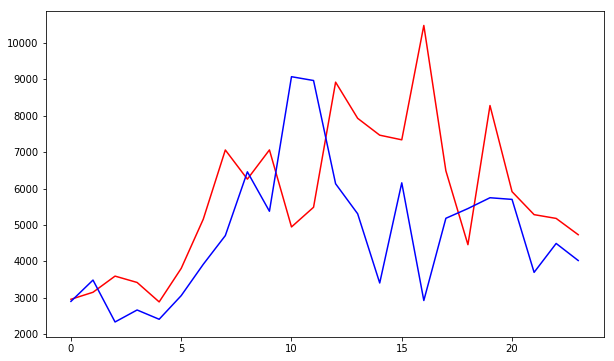

In [66]:
### Household demand curve for the considered day

hh_load_1 = pd.DataFrame((household_load_var[3][col]+1)*household_size[3])
day_hh_1 = pd.DataFrame(hh_load_1.values*household_load_day.values, columns=hh_load_1.columns, index=hh_load_1.index)
hh_load_2 = pd.DataFrame((household_load_var[4][col]+1)*household_size[4])
day_hh_2 = pd.DataFrame(hh_load_2.values*household_load_day.values, columns=hh_load_2.columns, index=hh_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_hh_1 ,'r')
plt.plot(day_hh_2,'b')
plt.show()


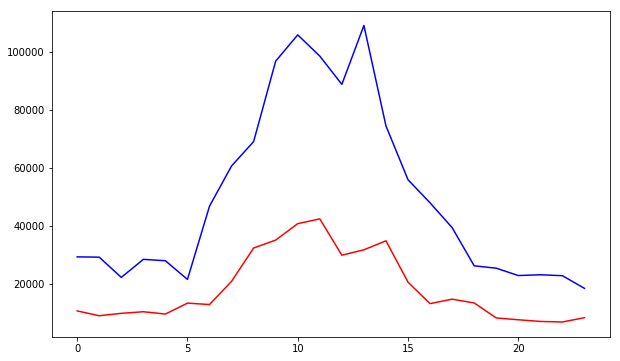

939

In [67]:
### Office demand curve for the considered day

off_load_1 = pd.DataFrame(office_load_v3[1][col])
day_oh_1 = pd.DataFrame(off_load_1.values*household_load_day.values, columns=off_load_1.columns, index=off_load_1.index)
off_load_2 = pd.DataFrame(office_load_v3[2][col])
day_oh_2 = pd.DataFrame(off_load_2.values*household_load_day.values, columns=off_load_2.columns, index=off_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_oh_1 ,'r')
plt.plot(day_oh_2,'b')
plt.show()
office_size[2]

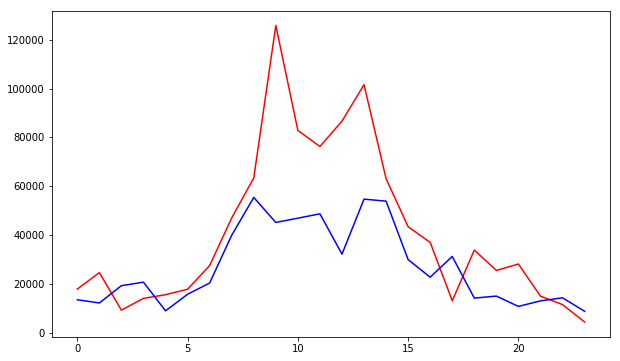

In [68]:
### School demand curve for the considered day

edu_load_1 = pd.DataFrame(education_load_v3[5][col])
day_eh_1 = pd.DataFrame(edu_load_1.values*household_load_day.values, columns=edu_load_1.columns, index=edu_load_1.index)
edu_load_2 = pd.DataFrame(education_load_v3[2][col])
day_eh_2 = pd.DataFrame(edu_load_2.values*household_load_day.values, columns=edu_load_2.columns, index=edu_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_eh_1 ,'r')
plt.plot(day_eh_2,'b')
plt.show()


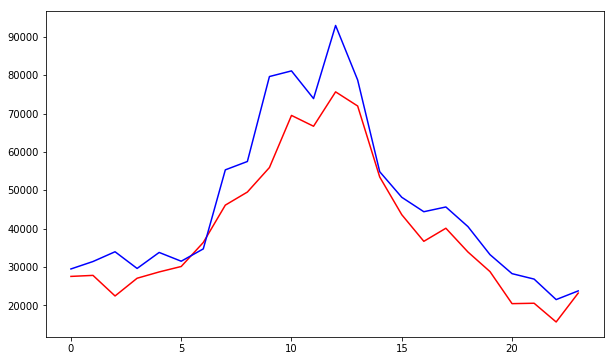

In [69]:
### Hospital demand curve for the considered day
hos_load_1 = pd.DataFrame(hospital_load_v3[1][col])
day_hosh_1 = pd.DataFrame(hos_load_1.values*household_load_day.values, columns=hos_load_1.columns, index=hos_load_1.index)
hos_load_2 = pd.DataFrame(hospital_load_v3[2][col])
day_hosh_2 = pd.DataFrame(hos_load_2.values*household_load_day.values, columns=hos_load_2.columns, index=edu_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_hosh_1 ,'r')
plt.plot(day_hosh_2,'b')
plt.show()

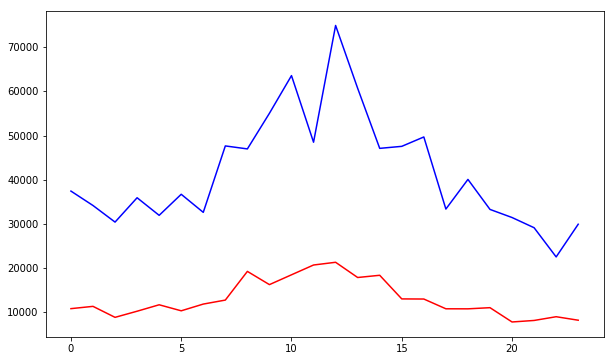

In [70]:
### Hotel/Restaurant demand curve for the considered day
hot_load_1 = pd.DataFrame(hotel_load_v3[1][col])
day_hoth_1 = pd.DataFrame(hot_load_1.values*household_load_day.values, columns=hot_load_1.columns, index=hot_load_1.index)
hot_load_2 = pd.DataFrame(hotel_load_v3[2][col])
day_hoth_2 = pd.DataFrame(hot_load_2.values*household_load_day.values, columns=hot_load_2.columns, index=hot_load_2.index)

plt.figure(1, figsize=(10, 6))
plt.plot(day_hoth_1 ,'r')
plt.plot(day_hoth_2,'b')
plt.show()

In [71]:
####################### Load Profils Generation END #############################
#################################################################################
### Give every spotload node a load profil. The loads are not assined towards the correct nodes/busses,
### since it is unknow yet, what kind of building is connected to which node/bus

hh_v_hour = pd.DataFrame(hh_v_hour)
off_load_hour = pd.DataFrame(off_load_hour)
edu_load_hour = pd.DataFrame(edu_load_hour)
hos_load_hour = pd.DataFrame(hos_load_hour)
hot_load_hour = pd.DataFrame(hot_load_hour)

load_list = pd.concat([hh_v_hour, off_load_hour, hos_load_hour, hot_load_hour, edu_load_hour], ignore_index = True)
load_list = load_list.rename(columns={0:'demand_kW'})

load_list['demand_kW'] = load_list['demand_kW'].astype(float)
load_list = load_list['demand_kW'] * household_load_pm_hour['Current']
load_list = pd.DataFrame(load_list)

In [72]:
section_spotload_demand = section_spotload.merge(load_list, left_index=True, right_index=True)
section_spotload_demand

,index,SectionID,FromNodeID,ToNodeID,demand_kW
0,6,42783662-SPOTLOAD,42783662,42783662-SPOTLOAD,1833.045389
1,11,42787380-SPOTLOAD,42787380,42787380-SPOTLOAD,4296.212337
2,15,42769314-SPOTLOAD,42769314,42769314-SPOTLOAD,7229.546234
3,21,42777729-SPOTLOAD,42777729,42777729-SPOTLOAD,5564.107630
4,48,42783479-SPOTLOAD,42783479,42783479-SPOTLOAD,2540.273554
5,52,42785340-SPOTLOAD,42785340,42785340-SPOTLOAD,3244.364495
6,56,42793224-SPOTLOAD,42793224,42793224-SPOTLOAD,853.626824
7,58,42767154-SPOTLOAD,42767154,42767154-SPOTLOAD,3981.709329
8,84,152492633-SPOTLOAD,152492633,152492633-SPOTLOAD,2003.453317
9,163,42937051-SPOTLOAD,42937051,42937051-SPOTLOAD,7582.860221


In [73]:
for _, load in section_spotload_demand.iterrows():
    bus_idx = pp.get_element_index(net, "bus", load.FromNodeID)
    phi = math.acos(95/100)
    pp.create_load(net, bus_idx, p_kw = load.demand_kW/1000, q_kvar = (math.tan(phi)*load.demand_kW)/1000 , const_z_percent=0, const_i_percent=0, 
                   name = "load "+ load.FromNodeID, scaling=1., in_service=True)
bus_idx

1262

In [74]:
net.load

,name,bus,p_kw,q_kvar,const_z_percent,const_i_percent,sn_kva,scaling,in_service,type
0,load 42783662,1469,1.833045,0.602493,0.0,0.0,NaN,1.0,True,None
1,load 42787380,892,4.296212,1.412097,0.0,0.0,NaN,1.0,True,None
2,load 42769314,1760,7.229546,2.376237,0.0,0.0,NaN,1.0,True,None
3,load 42777729,783,5.564108,1.828834,0.0,0.0,NaN,1.0,True,None
4,load 42783479,1501,2.540274,0.834948,0.0,0.0,NaN,1.0,True,None
5,load 42785340,820,3.244364,1.066371,0.0,0.0,NaN,1.0,True,None
6,load 42793224,1018,0.853627,0.280574,0.0,0.0,NaN,1.0,True,None
7,load 42767154,1648,3.981709,1.308725,0.0,0.0,NaN,1.0,True,None
8,load 152492633,288,2.003453,0.658503,0.0,0.0,NaN,1.0,True,None
9,load 42937051,395,7.582860,2.492366,0.0,0.0,NaN,1.0,True,None


In [75]:
solar_data_file = os.path.join('network_data/Timeseries_46.464_6.843_CM__1kWp_crystSi_14_37deg_-5deg_2016_2016.csv')

data_solar = pd.read_csv(solar_data_file, skiprows=10, skipfooter=12, engine='python')
data_solar.set_index(pd.to_datetime(data_solar["Date"], format="%Y%m%d:%H%M")+ pd.Timedelta(minutes=5), inplace=True)
data_solar = data_solar.drop('Date', 1)

radiation = data_solar.loc[date_time].EPV / 1000
radiation

0.30648999999999998

In [76]:
## Photovoltaics

section_pv['FromNodeID'].drop_duplicates()

pv_gen = pd.read_csv('network_data/pv_generator.csv', sep=',', header=0, decimal=',')
pv_gen['DeviceNumber'] = pv_gen['DeviceNumber'].apply(lambda x: x.split('-')[0])
pv_gen[["ActiveGeneration", "PowerFactor"]] = pv_gen[["ActiveGeneration", "PowerFactor"]].astype(float)
pv_gen = pv_gen[pv_gen['LoadModelName'] == 'MOYENNE']
pv_gen['ProducedActGen'] = pv_gen['ActiveGeneration']* radiation
pv_gen = pv_gen.drop_duplicates().reset_index(drop=True)

pv_gen

,DeviceNumber,DeviceType,LoadModelName,ActiveGeneration,PowerFactor,ProducedActGen
0,42778481,45,MOYENNE,12.81238,100.0,3.926866
1,42816058,45,MOYENNE,10.98204,100.0,3.365885
2,42819953,45,MOYENNE,7.32136,100.0,2.243924
3,42819954,45,MOYENNE,7.32136,100.0,2.243924
4,78874605,45,MOYENNE,10.98204,100.0,3.365885
5,42783662,45,MOYENNE,5.49102,100.0,1.682943
6,42783436,45,MOYENNE,3.66068,100.0,1.121962
7,42762511,45,MOYENNE,5.49102,100.0,1.682943
8,42787380,45,MOYENNE,7.32136,100.0,2.243924
9,42819955,45,MOYENNE,7.32136,100.0,2.243924


In [77]:
### Photovoltaics production of considered day, only needed for picture /curve

radiation_day = pd.DataFrame(data_solar.loc[date_start:date_end].EPV / 1000).reset_index(drop=True)
radiation_day = radiation_day['EPV'].astype(float)
ActGen_day = pd.DataFrame(pv_gen['ActiveGeneration'].astype(float)).reset_index(drop=True)

#pv_gen_day = ActGen_day['ActiveGeneration'].loc[1]
#ActGen_day.loc[1]
#pv_gen_day = [[0 for x in range(14)] for h in range(24)] # 14 pv systems and 24 hour
pv_gen_day = []

for i in range(14):
    pv_gen_day_v0 = []
    pv_gen_day_v0 =  radiation_day*ActGen_day['ActiveGeneration'].loc[i]
    pv_gen_day.append(pv_gen_day_v0)
pv_gen_day[13]

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.065197
9     0.641022
10    1.111273
11    1.654701
12    1.940563
13    1.418770
14    1.121962
15    0.394365
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
Name: EPV, dtype: float64

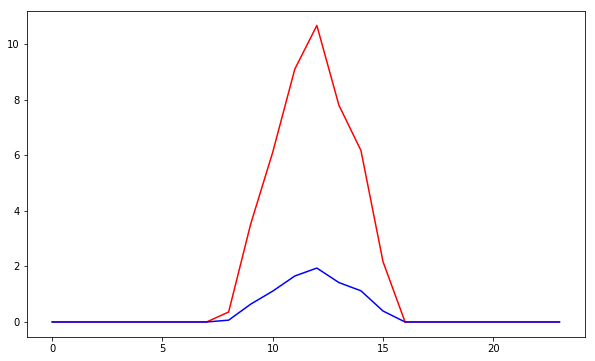

In [78]:
plt.figure(1, figsize=(10, 6))
plt.plot(pv_gen_day[11] ,'r')
plt.plot(pv_gen_day[13],'b')
plt.show()

In [79]:
# creating the pv table

for _,row in pv_gen.iterrows():
    phi = math.acos(row.PowerFactor/100)
    pp.create_sgen(net, pp.get_element_index(net, "bus", row.DeviceNumber), p_kw=-row.ProducedActGen,
                   q_kvar=(-1)*math.tan(phi)*row.ProducedActGen,sn_kva=row.ActiveGeneration, type='PV', name=row.DeviceNumber)

# show static generator table
#pv_gen
net.sgen

,name,bus,p_kw,q_kvar,sn_kva,scaling,in_service,type
0,42778481,1527,-3.926866,-0.0,12.81238,1.0,True,PV
1,42816058,1460,-3.365885,-0.0,10.98204,1.0,True,PV
2,42819953,769,-2.243924,-0.0,7.32136,1.0,True,PV
3,42819954,693,-2.243924,-0.0,7.32136,1.0,True,PV
4,78874605,743,-3.365885,-0.0,10.98204,1.0,True,PV
5,42783662,1469,-1.682943,-0.0,5.49102,1.0,True,PV
6,42783436,1133,-1.121962,-0.0,3.66068,1.0,True,PV
7,42762511,701,-1.682943,-0.0,5.49102,1.0,True,PV
8,42787380,892,-2.243924,-0.0,7.32136,1.0,True,PV
9,42819955,974,-2.243924,-0.0,7.32136,1.0,True,PV


In [80]:
pp.create_ext_grid(net, pp.get_element_index(net, "bus", '42879302'), vm_pu=1.03, va_degree=0, name='External grid',
                   s_sc_max_mva=10000, rx_max=0.1, rx_min=0.1) 


0

In [81]:
net.ext_grid # show external grid table

,name,bus,vm_pu,va_degree,in_service,s_sc_max_mva,rx_min,rx_max
0,External grid,316,1.03,0.0,True,10000.0,0.1,0.1


In [82]:
pp.runpp(net, max_iteration=10000)

In [83]:
net.res_load

,p_kw,q_kvar
0,1.833045,0.602493
1,4.296212,1.412097
2,7.229546,2.376237
3,5.564108,1.828834
4,2.540274,0.834948
5,3.244364,1.066371
6,0.853627,0.280574
7,3.981709,1.308725
8,2.003453,0.658503
9,7.582860,2.492366


In [84]:
net.res_sgen

,p_kw,q_kvar
0,-3.926866,-0.0
1,-3.365885,-0.0
2,-2.243924,-0.0
3,-2.243924,-0.0
4,-3.365885,-0.0
5,-1.682943,-0.0
6,-1.121962,-0.0
7,-1.682943,-0.0
8,-2.243924,-0.0
9,-2.243924,-0.0


In [85]:
net.res_bus
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(net.res_bus)

         vm_pu  va_degree         p_kw       q_kvar
0     1.019665   0.012580     0.000000     0.000000
1     1.019665   0.012580     0.000000     0.000000
2     1.019109   0.025625     0.000000     0.000000
3     1.018511   0.050496     0.000000     0.000000
4     1.020031   0.004197     0.000000     0.000000
5     1.018511   0.050496     0.000000     0.000000
6     1.019109   0.025625     0.000000     0.000000
7     1.018908   0.029969     0.000000     0.000000
8     1.021494  -0.008249     0.000000     0.000000
9     1.021494  -0.008249     0.000000     0.000000
10    1.019109   0.025625     0.000000     0.000000
11    1.019109   0.025625     0.000000     0.000000
12    1.020403  -0.000513     0.000000     0.000000
13    1.019665   0.012580     0.000000     0.000000
14    1.020043   0.003853     0.000000     0.000000
15    1.019666   0.012582     0.000000     0.000000
16    1.018475   0.053164     0.000000     0.000000
17    1.020801  -0.006226     0.000000     0.000000
18    1.0265

In [86]:
net.res_line

,p_from_kw,q_from_kvar,p_to_kw,q_to_kvar,pl_kw,ql_kvar,i_from_ka,i_to_ka,i_ka,loading_percent
0,-2.052289e+00,-1.412097e+00,2.052682e+00,1.412121e+00,3.933891e-04,2.413923e-05,3.574414e-03,3.574414e-03,3.574414e-03,3.249468e+00
1,-1.648711e+02,-6.973682e+01,1.658561e+02,6.993487e+01,9.849725e-01,1.980508e-01,2.582320e-01,2.582320e-01,2.582320e-01,1.721547e+02
2,1.689206e+02,7.155045e+01,-1.679088e+02,-7.134699e+01,1.011866e+00,2.034583e-01,2.617336e-01,2.617336e-01,2.617336e-01,1.744891e+02
3,1.560248e+02,6.701812e+01,-1.545500e+02,-6.672159e+01,1.474746e+00,2.965307e-01,2.470112e-01,2.470112e-01,2.470112e-01,1.646742e+02
4,-1.543042e+02,-6.663154e+01,1.545500e+02,6.672159e+01,2.457910e-01,9.005747e-02,2.470112e-01,2.470112e-01,2.470112e-01,9.686715e+01
5,4.681357e-12,-2.387380e-07,-4.601679e-12,5.893078e-08,7.967838e-14,-1.798072e-07,3.304017e-10,8.155731e-11,3.304017e-10,1.035742e-07
6,-1.544427e-11,4.910693e-08,1.575391e-11,-5.892682e-08,3.096448e-13,-9.819889e-09,6.796158e-11,8.155183e-11,8.155183e-11,2.556484e-08
7,1.519840e+01,-7.576816e+00,-1.518467e+01,7.580788e+00,1.372901e-02,3.972665e-03,2.343886e-02,2.343886e-02,2.343886e-02,8.341232e+00
8,-2.587834e+02,-1.505808e+02,2.591730e+02,1.507236e+02,3.896227e-01,1.427572e-01,4.398158e-01,4.398158e-01,4.398158e-01,1.724768e+02
9,2.660563e+02,1.533686e+02,-2.591730e+02,-1.507236e+02,6.883334e+00,2.645070e+00,4.398158e-01,4.398158e-01,4.398158e-01,1.999163e+02


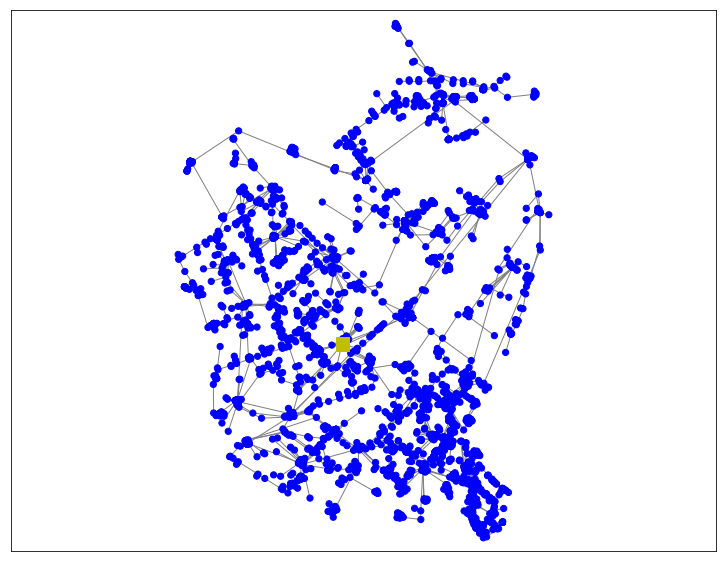

In [87]:
from pandapower.plotting.plotly import simple_plotly

plot.simple_plot(net, bus_size=0.7, respect_switches = True) # , on_map=True, projection='epsg:'


/home/bigboss/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


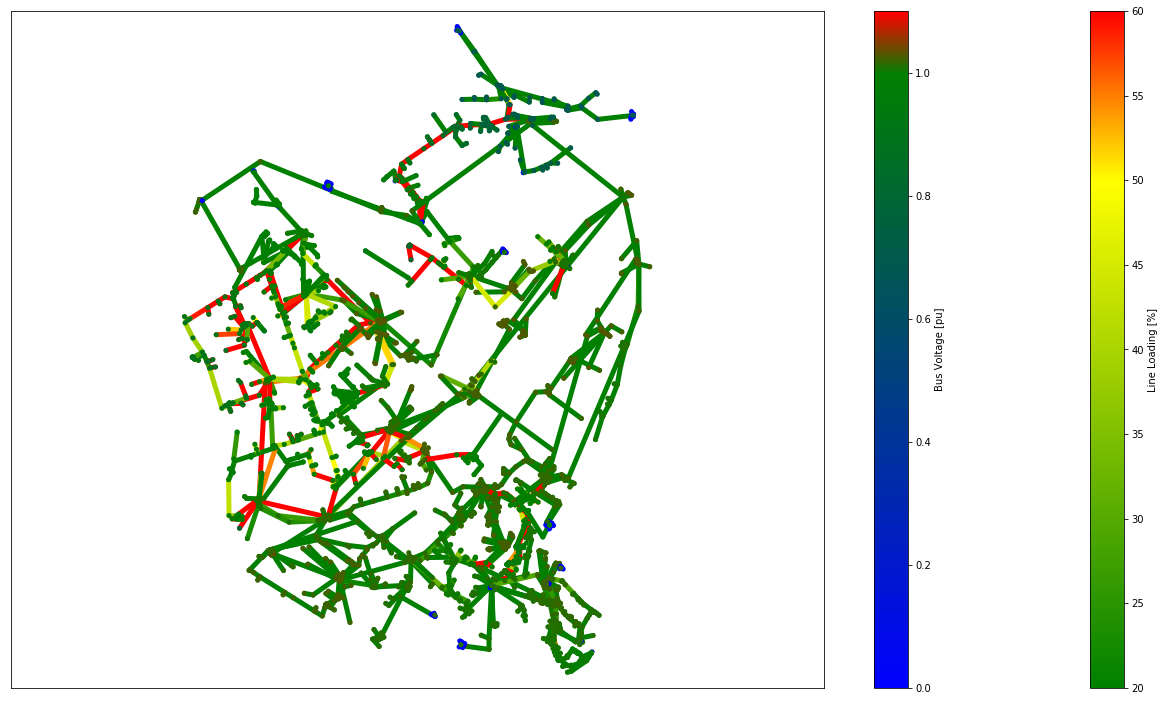

In [88]:
cmap_list=[(20, "green"), (50, "yellow"), (60, "red")]
cmap, norm = plot.cmap_continous(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=5)

cmap_list=[(0, "blue"), (1.0, "green"), (1.1, "red")]
cmap, norm = plot.cmap_continous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=5, zorder=2, cmap=cmap, norm=norm)

loadc = plot.create_bus_collection(net, net.load.index, size=5, zorder=2, norm=norm)
pvc = plot.create_bus_collection(net, net.sgen.index, size=5, zorder=1, norm=norm)
plot.draw_collections([lc, bc], figsize=(18,10))


In [89]:
net.bus
with open('result_data_v2/bus.json', 'w') as outfile:
    json.dump(net.bus.to_json(), outfile)

In [90]:
net.bus_geodata
with open('result_data_v2/bus_geodata.json', 'w') as outfile:
    json.dump(net.bus_geodata.to_json(), outfile)

In [91]:
net.line
with open('result_data_v2/line.json', 'w') as outfile:
    json.dump(net.line.to_json(), outfile)

In [92]:
net.line_geodata
with open('result_data_v2/line_geodata.json', 'w') as outfile:
    json.dump(net.line_geodata.to_json(), outfile)

In [93]:
net.trafo
with open('result_data_v2/trafo.json', 'w') as outfile:
    json.dump(net.trafo.to_json(), outfile)

In [94]:
net.switch
with open('result_data_v2/switch.json', 'w') as outfile:
    json.dump(net.switch.to_json(), outfile)

In [95]:
net.load
with open('result_data_v2/load.json', 'w') as outfile:
    json.dump(net.load.to_json(), outfile)

In [96]:
net.sgen
with open('result_data_v2/sgen.json', 'w') as outfile:
    json.dump(net.sgen.to_json(), outfile)

In [97]:
net.ext_grid
with open('result_data_v2/ext_grid.json', 'w') as outfile:
    json.dump(net.ext_grid.to_json(), outfile)